# Audio Classification

텍스트, 이미지 분야가 아닌 오디오 분야의 딥러닝을 공부했습니다.
오디오 분야에서 가장 많이 쓰이고 중요한 패키지는 librosa입니다!

In [187]:
!pip install librosa

In [188]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm_notebook
import librosa
import librosa.display
import keras
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from sklearn.model_selection import train_test_split
from glob import glob
import _pickle as cPickle

# data 분석

오픈 데이터인 도시에서 나는 소리 데이터이며, 데이터의 경로를 설정하고 데이터의 파일명과 오디오의 Class를 확인.

In [189]:
data_path = './data/'

dataset_dir = os.path.join(data_path,'train')
test_dir = os.path.join(data_path, 'test')

In [190]:
dataset_list = pd.read_csv('./data/train.csv')
test_dataset_list = pd.read_csv('./data/test.csv')

dataset_list.head()

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark


In [191]:
test_dataset_list.head()

,ID,Class
0,8046,siren
1,8047,car_horn
2,8048,engine_idling
3,8049,car_horn
4,8050,car_horn


학습할 데이터는 총 5000개이며, test 데이터는 435개이며 class는 10개로 분류되어 있습니다.

In [192]:
print("Number of training data=", dataset_list.shape[0],"Number of classes=",
      len(dataset_list.Class. unique()))

Number of training data= 5000 Number of classes= 10


In [193]:
print("Number of training data=", test_dataset_list.shape[0],"Number of classes=",
      len(test_dataset_list.Class. unique()))

Number of training data= 435 Number of classes= 10


In [194]:
dataset_label = dataset_list[['Class']]

x = dataset_label.groupby('Class')['Class'].count()
x

Class
air_conditioner     554
car_horn            280
children_playing    550
dog_bark            553
drilling            550
engine_idling       567
gun_shot            216
jackhammer          624
siren               548
street_music        558
Name: Class, dtype: int64

In [195]:
test_label = test_dataset_list.groupby('Class')['Class'].count()
test_label

Class
air_conditioner     46
car_horn            26
children_playing    50
dog_bark            47
drilling            50
engine_idling       57
gun_shot            14
jackhammer          44
siren               59
street_music        42
Name: Class, dtype: int64

wav 형식으로 되어있는 오디오 파일을 쉽게 불러오기 위해 dataframe안에 path라는 변수에 데이터 경로와 파일명 생성.

In [204]:
dataset_list['path'] = dataset_dir+ '/' + dataset_list['ID'].astype('str')+".wav"
print(dataset_list.path[0])
dataset_list.head(7)

./data/train/0.wav


,ID,Class,path
0,0,siren,./data/train/0.wav
1,1,street_music,./data/train/1.wav
2,2,drilling,./data/train/2.wav
3,3,siren,./data/train/3.wav
4,4,dog_bark,./data/train/4.wav
5,6,children_playing,./data/train/6.wav
6,10,street_music,./data/train/10.wav


In [205]:
test_dataset_list['path'] = test_dir+ '/' + test_dataset_list['ID'].astype('str')+".wav"
print(test_dataset_list.path[0])
test_dataset_list.head(7)

./data/test/8046.wav


,ID,Class,path
0,8046,siren,./data/test/8046.wav
1,8047,car_horn,./data/test/8047.wav
2,8048,engine_idling,./data/test/8048.wav
3,8049,car_horn,./data/test/8049.wav
4,8050,car_horn,./data/test/8050.wav
5,8052,street_music,./data/test/8052.wav
6,8053,street_music,./data/test/8053.wav


# 오디오 데이터의 시각화

오디오 데이터는 feature를 추출하는 여러 방법들과 여러 분석 방법들이 있습니다. 예를 들어 melspectrogram을 통해서, mfcc 등을 통해서 할 수 있습니다.

In [196]:
sample1=dataset_dir+'/0.wav'
duration=2.97 
sr=22050

y1, sr1 = librosa.load(sample1, duration=duration,  sr=sr)
ps1 = librosa.feature.melspectrogram(y=y1, sr=sr1)

input_length=sr*duration
offset1 = len(y1) - round(input_length)
print ("input:", round(input_length), " load:", len(y1) , " offset:", offset1)
print ("y shape:", y1.shape, " melspec shape:", ps1.shape)

input: 65489  load: 65489  offset: 0
y shape: (65489,)  melspec shape: (128, 128)


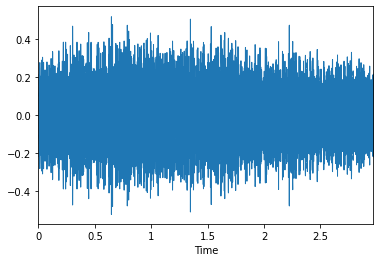

In [197]:
librosa.display.waveplot(y1,sr1)

In [198]:
ipd.Audio(sample1)

(128, 128)

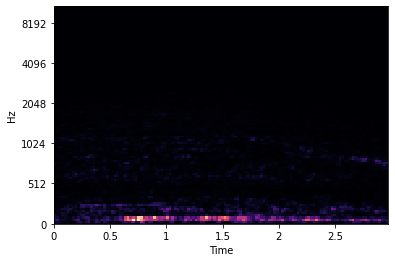

In [199]:
librosa.display.specshow(ps1, y_axis='mel', x_axis='time')
ps1.shape

In [200]:
sample2=dataset_dir+'/1043.wav'

y2, sr2 = librosa.load(sample2, duration=duration,  sr=sr)
ps2 = librosa.feature.melspectrogram(y=y2, sr=sr2)

input_length=sr*duration
offset2 = len(y2) - round(input_length)
print ("input:", round(input_length), " load:", len(y2) , " offset:", offset2)
print ("y shape:", y2.shape, " melspec shape:", ps2.shape)

input: 65489  load: 65489  offset: 0
y shape: (65489,)  melspec shape: (128, 128)


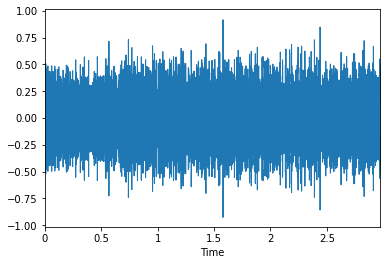

In [201]:
librosa.display.waveplot(y2,sr2)

In [202]:
ipd.Audio(sample2)

(128, 128)

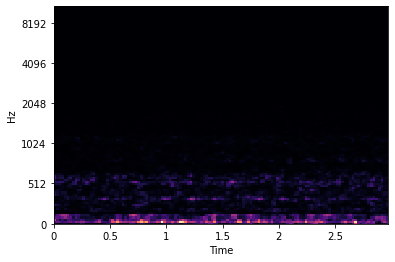

In [203]:
librosa.display.specshow(ps2, y_axis='mel', x_axis='time')
ps1.shape

# 데이터 전처리

앞에서 하나의 예제 데이터에 적용했던 것을 학습 데이터와 테스트 데이터 모든 데이터에 적용하고자 합니다. 그리고 128*128의 shape를 만듭니다.

In [206]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5


audio_play_duration=2.97

def load_audio_file(file_path, duration=2.97, sr=22050):

    input_length=sr*duration
    # Load an audio file as a floating point time series.
    # y : np.ndarray [shape=(n,) or (2, n)] - audio time series
    # sr : number > 0 [scalar] - sampling rate of y
    y, sr = librosa.load(file_path,sr=sr, duration=duration)
    dur = librosa.get_duration(y=y)

    if (round(dur) < duration):
        offset = len(y) - round(input_length)
        print ("fixing audio length :", file_path)
        print ("input:", round(input_length), " load:", len(y) , " offset:", offset)
        y = librosa.util.fix_length(y, round(input_length))      
  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    return ps

In [207]:
audio_data = [] 
object_file='saved_audio_data.p'


if not os.path.isfile(object_file):
    SKIP_AUDIO_RELOAD = False


if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading data from audio files")
else:
    print ("loading audio data, may take a few minutes. please wait!")
    for row in tqdm_notebook(dataset_list.itertuples()):
        ps = load_audio_file(file_path=row.path, duration=2.97)
        if ps.shape != (128, 128): continue
        audio_data.append( (ps, row.Class) ) 
    print("Number of train samples: ", len(audio_data))

loading audio data, may take a few minutes. please wait!


<ipython-input-207-cfdf864f2ba7>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for row in tqdm_notebook(dataset_list.itertuples()):


0it [00:00, ?it/s]

fixing audio length : ./data/train/12.wav
input: 65489  load: 25104  offset: -40385
fixing audio length : ./data/train/19.wav
input: 65489  load: 43169  offset: -22320
fixing audio length : ./data/train/48.wav
input: 65489  load: 3954  offset: -61535
fixing audio length : ./data/train/52.wav
input: 65489  load: 31973  offset: -33516
fixing audio length : ./data/train/57.wav
input: 65489  load: 46526  offset: -18963
fixing audio length : ./data/train/59.wav
input: 65489  load: 50665  offset: -14824
fixing audio length : ./data/train/61.wav
input: 65489  load: 28353  offset: -37136
fixing audio length : ./data/train/78.wav
input: 65489  load: 8379  offset: -57110
fixing audio length : ./data/train/83.wav
input: 65489  load: 2337  offset: -63152
fixing audio length : ./data/train/101.wav
input: 65489  load: 25358  offset: -40131
fixing audio length : ./data/train/116.wav
input: 65489  load: 41141  offset: -24348
fixing audio length : ./data/train/123.wav
input: 65489  load: 46967  offset:

fixing audio length : ./data/train/1082.wav
input: 65489  load: 36356  offset: -29133
fixing audio length : ./data/train/1182.wav
input: 65489  load: 1323  offset: -64166
fixing audio length : ./data/train/1189.wav
input: 65489  load: 23721  offset: -41768
fixing audio length : ./data/train/1205.wav
input: 65489  load: 24876  offset: -40613
fixing audio length : ./data/train/1219.wav
input: 65489  load: 5292  offset: -60197
fixing audio length : ./data/train/1228.wav
input: 65489  load: 30429  offset: -35060
fixing audio length : ./data/train/1231.wav
input: 65489  load: 30161  offset: -35328
fixing audio length : ./data/train/1243.wav
input: 65489  load: 4190  offset: -61299
fixing audio length : ./data/train/1244.wav
input: 65489  load: 25137  offset: -40352
fixing audio length : ./data/train/1246.wav
input: 65489  load: 23271  offset: -42218
fixing audio length : ./data/train/1252.wav
input: 65489  load: 43627  offset: -21862
fixing audio length : ./data/train/1276.wav
input: 65489 

fixing audio length : ./data/train/2233.wav
input: 65489  load: 12267  offset: -53222
fixing audio length : ./data/train/2246.wav
input: 65489  load: 51810  offset: -13679
fixing audio length : ./data/train/2265.wav
input: 65489  load: 43439  offset: -22050
fixing audio length : ./data/train/2291.wav
input: 65489  load: 36603  offset: -28886
fixing audio length : ./data/train/2295.wav
input: 65489  load: 34398  offset: -31091
fixing audio length : ./data/train/2302.wav
input: 65489  load: 6080  offset: -59409
fixing audio length : ./data/train/2304.wav
input: 65489  load: 28886  offset: -36603
fixing audio length : ./data/train/2327.wav
input: 65489  load: 52700  offset: -12789
fixing audio length : ./data/train/2380.wav
input: 65489  load: 6615  offset: -58874
fixing audio length : ./data/train/2390.wav
input: 65489  load: 11687  offset: -53802
fixing audio length : ./data/train/2398.wav
input: 65489  load: 25132  offset: -40357
fixing audio length : ./data/train/2404.wav
input: 65489

fixing audio length : ./data/train/3395.wav
input: 65489  load: 23373  offset: -42116
fixing audio length : ./data/train/3416.wav
input: 65489  load: 16669  offset: -48820
fixing audio length : ./data/train/3423.wav
input: 65489  load: 37044  offset: -28445
fixing audio length : ./data/train/3445.wav
input: 65489  load: 21126  offset: -44363
fixing audio length : ./data/train/3458.wav
input: 65489  load: 18442  offset: -47047
fixing audio length : ./data/train/3470.wav
input: 65489  load: 32997  offset: -32492
fixing audio length : ./data/train/3489.wav
input: 65489  load: 17199  offset: -48290
fixing audio length : ./data/train/3492.wav
input: 65489  load: 13440  offset: -52049
fixing audio length : ./data/train/3514.wav
input: 65489  load: 52909  offset: -12580
fixing audio length : ./data/train/3526.wav
input: 65489  load: 19167  offset: -46322
fixing audio length : ./data/train/3543.wav
input: 65489  load: 37485  offset: -28004
fixing audio length : ./data/train/3547.wav
input: 654

fixing audio length : ./data/train/4742.wav
input: 65489  load: 31215  offset: -34274
fixing audio length : ./data/train/4747.wav
input: 65489  load: 19345  offset: -46144
fixing audio length : ./data/train/4752.wav
input: 65489  load: 29327  offset: -36162
fixing audio length : ./data/train/4793.wav
input: 65489  load: 11246  offset: -54243
fixing audio length : ./data/train/4796.wav
input: 65489  load: 28125  offset: -37364
fixing audio length : ./data/train/4830.wav
input: 65489  load: 46730  offset: -18759
fixing audio length : ./data/train/4842.wav
input: 65489  load: 11849  offset: -53640
fixing audio length : ./data/train/4847.wav
input: 65489  load: 29547  offset: -35942
fixing audio length : ./data/train/4860.wav
input: 65489  load: 50936  offset: -14553
fixing audio length : ./data/train/4864.wav
input: 65489  load: 39170  offset: -26319
fixing audio length : ./data/train/4880.wav
input: 65489  load: 25735  offset: -39754
fixing audio length : ./data/train/4887.wav
input: 654

fixing audio length : ./data/train/5773.wav
input: 65489  load: 49080  offset: -16409
fixing audio length : ./data/train/5780.wav
input: 65489  load: 52700  offset: -12789
fixing audio length : ./data/train/5796.wav
input: 65489  load: 44762  offset: -20727
fixing audio length : ./data/train/5817.wav
input: 65489  load: 39466  offset: -26023
fixing audio length : ./data/train/5818.wav
input: 65489  load: 7056  offset: -58433
fixing audio length : ./data/train/5847.wav
input: 65489  load: 16758  offset: -48731
fixing audio length : ./data/train/5851.wav
input: 65489  load: 39029  offset: -26460
fixing audio length : ./data/train/5862.wav
input: 65489  load: 20948  offset: -44541
fixing audio length : ./data/train/5888.wav
input: 65489  load: 29106  offset: -36383
fixing audio length : ./data/train/5890.wav
input: 65489  load: 16538  offset: -48951
fixing audio length : ./data/train/5907.wav
input: 65489  load: 35501  offset: -29988
fixing audio length : ./data/train/5912.wav
input: 6548

fixing audio length : ./data/train/6991.wav
input: 65489  load: 13230  offset: -52259
fixing audio length : ./data/train/7006.wav
input: 65489  load: 20713  offset: -44776
fixing audio length : ./data/train/7018.wav
input: 65489  load: 23142  offset: -42347
fixing audio length : ./data/train/7028.wav
input: 65489  load: 54232  offset: -11257
fixing audio length : ./data/train/7029.wav
input: 65489  load: 26622  offset: -38867
fixing audio length : ./data/train/7032.wav
input: 65489  load: 31036  offset: -34453
fixing audio length : ./data/train/7036.wav
input: 65489  load: 19184  offset: -46305
fixing audio length : ./data/train/7053.wav
input: 65489  load: 49147  offset: -16342
fixing audio length : ./data/train/7064.wav
input: 65489  load: 46964  offset: -18525
fixing audio length : ./data/train/7074.wav
input: 65489  load: 34178  offset: -31311
fixing audio length : ./data/train/7083.wav
input: 65489  load: 51597  offset: -13892
fixing audio length : ./data/train/7108.wav
input: 654

fixing audio length : ./data/train/7944.wav
input: 65489  load: 31973  offset: -33516
fixing audio length : ./data/train/7956.wav
input: 65489  load: 37485  offset: -28004
fixing audio length : ./data/train/7969.wav
input: 65489  load: 30209  offset: -35280
fixing audio length : ./data/train/7976.wav
input: 65489  load: 17640  offset: -47849
fixing audio length : ./data/train/7997.wav
input: 65489  load: 9702  offset: -55787
fixing audio length : ./data/train/7998.wav
input: 65489  load: 17775  offset: -47714
fixing audio length : ./data/train/8008.wav
input: 65489  load: 3667  offset: -61822
fixing audio length : ./data/train/8009.wav
input: 65489  load: 14030  offset: -51459
fixing audio length : ./data/train/8016.wav
input: 65489  load: 23373  offset: -42116
fixing audio length : ./data/train/8024.wav
input: 65489  load: 28224  offset: -37265
Number of train samples:  4949


In [209]:
test_audio_data = []
test_object_file='saved_test_audio_data.p'


if not os.path.isfile(test_object_file):
    SKIP_AUDIO_RELOAD = False

if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TEST data from audio files")
else:
    print ("loading test audio data, may take a few minutes. please wait!")
    for row in tqdm_notebook(test_dataset_list.itertuples()):
        ps = load_audio_file(file_path=row.path, duration=2.97)
        if ps.shape != (128, 128): continue
        test_audio_data.append( (ps, row.Class) ) 
    print("Number of train samples: ", len(test_audio_data))

loading test audio data, may take a few minutes. please wait!


<ipython-input-209-79fd987910d8>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for row in tqdm_notebook(test_dataset_list.itertuples()):


0it [00:00, ?it/s]

fixing audio length : ./data/test/8049.wav
input: 65489  load: 21830  offset: -43659
fixing audio length : ./data/test/8050.wav
input: 65489  load: 2137  offset: -63352
fixing audio length : ./data/test/8064.wav
input: 65489  load: 36987  offset: -28502
fixing audio length : ./data/test/8088.wav
input: 65489  load: 4325  offset: -61164
fixing audio length : ./data/test/8092.wav
input: 65489  load: 41454  offset: -24035
fixing audio length : ./data/test/8097.wav
input: 65489  load: 24878  offset: -40611
fixing audio length : ./data/test/8105.wav
input: 65489  load: 47960  offset: -17529
fixing audio length : ./data/test/8128.wav
input: 65489  load: 10706  offset: -54783
fixing audio length : ./data/test/8148.wav
input: 65489  load: 15842  offset: -49647
fixing audio length : ./data/test/8151.wav
input: 65489  load: 22883  offset: -42606
fixing audio length : ./data/test/8154.wav
input: 65489  load: 24444  offset: -41045
fixing audio length : ./data/test/8168.wav
input: 65489  load: 3505

이 과정을 통해서 size가 128*128이 아닌 데이터는 필터링 되었으며 겨국 학습 데이터에 4949개, 433개가 남게 되었습니다.

In [208]:
if SKIP_AUDIO_RELOAD is True:
    audio_data = cPickle.load(open(object_file, 'rb'))
    print ("loaded train data [%s] records from object file" % len(audio_data))  
else:
    cPickle.dump(audio_data, open(object_file, 'wb')) 
    print ("saved loaded train data :",len(audio_data))

saved loaded train data : 4949


In [210]:
if SKIP_AUDIO_RELOAD is True:
    test_audio_data = cPickle.load(open(test_object_file, 'rb'))
    print ("loaded test data [%s] records from object file" % len(test_audio_data))      
else:
    cPickle.dump(test_audio_data, open(test_object_file, 'wb')) 
    print ("save loaded test data :", len(test_audio_data))

save loaded test data : 433


In [211]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical as to_categorical
from numpy import argmax

오디오 데이터 input 부분을 전처리 했다면 이제 class 부분 output 부분을 전처리 합니다.
단어로 정의되어 있던 값을 숫자 값으로 라벨링 인코딩 합니다.

In [212]:
list_labels = sorted(list(set(dataset_list.Class.values)))
print ("unique text labels count: ",len(list_labels))
print ("labels: ",list_labels)

# integer encode
label_encoder = LabelEncoder()
label_integer_encoded = label_encoder.fit_transform(list_labels)
print("encoded labelint values", label_integer_encoded)

# one hot encode
encoded_test = to_categorical(label_integer_encoded)
inverted_test = argmax(encoded_test[0])
#print(encoded_test, inverted_test)

#map filename to label
file_to_label = {k:v for k,v in zip(dataset_list.path.values, dataset_list.ID.values)}

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(list_labels)}
#print ("test label to int ",label_to_int["Applause"])

# map integer to text labels
int_to_label = {v:k for k,v in label_to_int.items()}

unique text labels count:  10
labels:  ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
encoded labelint values [0 1 2 3 4 5 6 7 8 9]


In [213]:
list_labels = sorted(list(set(test_dataset_list.Class.values)))
print ("unique text labels count: ",len(list_labels))
print ("labels: ",list_labels)

# integer encode
label_encoder = LabelEncoder()
label_integer_encoded = label_encoder.fit_transform(list_labels)
print("encoded labelint values", label_integer_encoded)

# one hot encode
encoded_test = to_categorical(label_integer_encoded)
inverted_test = argmax(encoded_test[0])
#print(encoded_test, inverted_test)

#map filename to label
file_to_label = {k:v for k,v in zip(test_dataset_list.path.values, test_dataset_list.ID.values)}

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(list_labels)}
#print ("test label to int ",label_to_int["Applause"])

# map integer to text labels
int_to_label = {v:k for k,v in label_to_int.items()}

unique text labels count:  10
labels:  ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
encoded labelint values [0 1 2 3 4 5 6 7 8 9]


학습 데이터를 8:2 비율로 train 데이터 3959, validation 데이터 990를 생성하며, sample수,128,128,1로 reshape한후 array화 해줍니다.

In [214]:
X, Y = zip(*audio_data)
x_test, y_test = zip(*test_audio_data)

x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=14)

In [215]:
x_train = np.array([x.reshape( (128, 128, 1) ) for x in x_train])
x_valid = np.array([x.reshape( (128, 128, 1) ) for x in x_valid])
x_test = np.array([x.reshape( (128, 128, 1) ) for x in x_test])

print ("train ",x_train.shape, len(y_train))
print ("valid ", x_valid.shape, len(y_valid))
print ("test ", x_test.shape, len(y_test))

train  (3959, 128, 128, 1) 3959
valid  (990, 128, 128, 1) 990
test  (433, 128, 128, 1) 433


In [216]:
label_encoder = LabelEncoder()
y_train_integer_encoded = label_encoder.fit_transform(y_train)
y_valid_integer_encoded = label_encoder.fit_transform(y_valid)
y_test_integer_encoded = label_encoder.fit_transform(y_test)

In [217]:
y_train = np.array(to_categorical(y_train_integer_encoded, len(list_labels)))
y_valid = np.array(to_categorical(y_valid_integer_encoded, len(list_labels)))
y_test = np.array(to_categorical(y_test_integer_encoded, len(list_labels)))

# Model 만들기 및 훈련

In [218]:
model = Sequential()
input_shape= x_train.shape[1:] 

model.add(layers.Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(layers.MaxPooling2D((4, 2), strides=(4, 2)))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(48, (5, 5), padding="valid"))
model.add(layers.MaxPooling2D((4, 2), strides=(4, 2)))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(48, (5, 5), padding="valid"))
model.add(layers.Activation('relu'))

model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(len(list_labels)))
model.add(layers.Activation('softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 124, 124, 24)      624       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 62, 24)        0         
_________________________________________________________________
activation_5 (Activation)    (None, 31, 62, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 58, 48)        28848     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 29, 48)         0         
_________________________________________________________________
activation_6 (Activation)    (None, 6, 29, 48)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 25, 48)        

In [219]:
MAX_EPOCHS=30
MAX_BATCH_SIZE=16
# learning rate reduction rate 
MAX_PATIENT=2  

# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]


model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=['accuracy'])


print('training started.... please wait!')
history = model.fit(x=x_train, y=y_train,
                    epochs=MAX_EPOCHS,
                    batch_size=MAX_BATCH_SIZE,
                    validation_data= (x_valid, y_valid), 
                    callbacks=callback)
print('training finished')



training started.... please wait!
Epoch 1/30
248/248 [==============================] - 37s 148ms/step - loss: 2.7687 - accuracy: 0.1591 - val_loss: 2.0910 - val_accuracy: 0.3010

Epoch 00001: loss improved from inf to 2.41973, saving model to ./best_model_trained.hdf5
Epoch 2/30
248/248 [==============================] - 37s 151ms/step - loss: 2.0783 - accuracy: 0.2902 - val_loss: 1.9027 - val_accuracy: 0.3636

Epoch 00002: loss improved from 2.41973 to 2.02957, saving model to ./best_model_trained.hdf5
Epoch 3/30
248/248 [==============================] - 35s 143ms/step - loss: 1.8501 - accuracy: 0.3522 - val_loss: 1.6822 - val_accuracy: 0.4394

Epoch 00003: loss improved from 2.02957 to 1.82360, saving model to ./best_model_trained.hdf5
Epoch 4/30
248/248 [==============================] - 37s 149ms/step - loss: 1.6831 - accuracy: 0.4214 - val_loss: 1.6022 - val_accuracy: 0.4697

Epoch 00004: loss improved from 1.82360 to 1.63431, saving model to ./best_model_trained.hdf5
Epoch 5/30

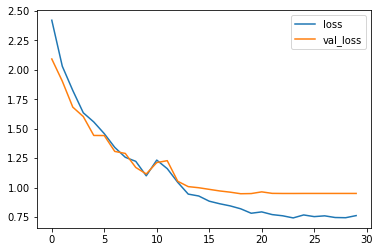

In [220]:
metrics = history. history
plt.plot(history.epoch, metrics['loss'],metrics['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

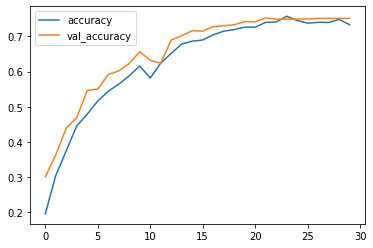

In [222]:
metrics = history. history
plt.plot(history.epoch, metrics['accuracy'],metrics['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

약 20epoch부터 val_loss가 감소하지 않는 것을 볼 수 있으며 꽤나 높은 loss를 기록하는 것을 확인할 수 있으며, accuracy도 어느정도 수준에서 쭉 머무르고 있는 것을 확인할 수 있다.

# test 데이터로 성능 평가 

In [223]:
# quick evaludate model
print('Evaluate model with test data')
score = model.evaluate(x=x_test,y=y_test)

print('test loss:', score[0])
print('test accuracy:', score[1])

Evaluate model with test data
14/14 [==============================] - 0s 23ms/step - loss: 1.0427 - accuracy: 0.7298
test loss: 1.0427486896514893
test accuracy: 0.7297921180725098


test 데이터에 대해 0.73정도의 정확도를 기록했으며, loss가 높은 점을 개선해야 한다.